<a href="https://colab.research.google.com/github/hsoJLeu/resumAI/blob/master/ResumAI_Final_Sourcecode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**ResumAI**
***created by Brandon Nguyen, Curtis Lee, and Joshua Leung for CMPS 144 at UCSC***

In [0]:
import pandas as pd
import numpy as np
import io

# matplot imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Keras imports
import keras
from keras.preprocessing import text, sequence
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input, Dense
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import text_to_word_sequence
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import utils

# Sklearn imports
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

# NLTK imports
import nltk

from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

Using TensorFlow backend.


In [0]:

# Import raw csv from github
url = 'https://raw.githubusercontent.com/hsoJLeu/resumAI/master/data/resume_dataset.csv'               # original data
# url = 'https://raw.githubusercontent.com/hsoJLeu/resumAI/master/data/Clean-Culture.csv'                  # Only engineering and IT

df = pd.read_csv(url)
df.head()

,ID,Category,Resume
0,1,HR,"b'John H. Smith, P.H.R.\n800-991-5187 | PO Box..."
1,2,HR,b'Name Surname\nAddress\nMobile No/Email\nPERS...
2,3,HR,b'Anthony Brown\nHR Assistant\nAREAS OF EXPERT...
3,4,HR,b'www.downloadmela.com\nSatheesh\nEMAIL ID:\nC...
4,5,HR,"b""HUMAN RESOURCES DIRECTOR\n\xef\x82\xb7Expert..."


In [0]:
# Data cleaning

from io import StringIO
col = ['Category', 'Resume']
df = df[col]
df = df[pd.notnull(df['Resume'])]
df.columns = ['Category', 'Resume']
df['category_id'] = df['Category'].factorize()[0]
# clean category -> category Id

# #DROPPING ROW 132 because it messes things up
# df.drop(df.index[132])

category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

# Drop resumes if data contain b'' there are 12 of these in our dataset
# Empty resumes in the dataset, one hot can't encode empty resumes

df = df[df['Resume'].map(len) > 4]

# Get a count for resumes in the dataframe so that we can fix overfitting issues
df['count_resumes'] = df.groupby(['Category', 'category_id'])['category_id'].transform('count')
  
# To look at count of resumes per category  
countDF = df[['Category', 'count_resumes']]
#print("Number of resumes per category:")
countDF.drop_duplicates(subset='Category', keep="first")

df = df.reset_index(drop=True)

In [0]:


resume_list = df['Resume']            # get resume list
category_list = df['Category']        # get category list
category_id_list = df['category_id']  # get category id list

# print(category_list[132])

In [0]:
# for i in range(0, len(resume_list)):
# #   if i is not 132:
#     print(category_list[i])

##Clean and preprocess data

In [0]:
# This part applies regex and cleans data in resume field 

from keras.preprocessing.text import one_hot
from keras.preprocessing.text import text_to_word_sequence

nltk.download('stopwords')
import re

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    # Get rid of the unicodes starting with \
    doc = re.sub(r'[^\x00-\xff]',r'', doc) 
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)
norm_corpus = normalize_corpus(resume_list)
norm_corpus # this is a numpy array & cleaned out data

# test
resume_list = norm_corpus
resume_list

# resume_corpus_list = []
# for corpus in norm_corpus:
#   length_corpus = len(corpus)
#   filter_text = keras.preprocessing.text.one_hot(corpus, length_corpus, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')
#   resume_corpus_list.append(filter_text)

# # corpus_list
# resume_corpus_list

# STEM ONLY IF NEEDED
# porter = PorterStemmer()
# stemmed = [porter.stem(word) for word in corpus_list]
# print(stemmed[:500]) # Stemmed

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


array(["bjohn h smith phrn po box callahan fl infogreatresumesfastcomnnapproachable innovator passion human resourcesnnsenior human resources professionalnpersonable analytical flexible senior hr professional multifaceted expertise seasoned benefits administrator withnextensive experience working highly paid professionals clientrelationshipbased settings dynamic team leaderncapable analyzing alternatives identifying tough choices communicating total value benefit andncompensation packages senior level executives employeesnncore competenciesnbenefits administration xexx customer service xexx cost control xexx recruiting xexx acquisition management xexx compliance reportingnretention xexx professional services xexx domestic international benefits xexx collaboration xexx adaptability xexx change managementndefined contribution plans xexx auditing xexx negotiation xexx corporate hr policies xexx full lifecycle training xexx k xexx form nconfidential files xexx eeo xexx aap xexx fmla xexx s

## Split our data here

In [0]:
# Split resume and category into training and test data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(resume_list, category_list, test_size = 0.2, random_state=0)

In [0]:
len(X_train)
len(y_train)

964

In [0]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from keras import utils

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(X_train) # only fit on train


x_train = tokenize.texts_to_matrix(X_train)
x_test = tokenize.texts_to_matrix(X_test)

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 30


## Bag of words model

In [0]:
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 867 samples, validate on 97 samples
Epoch 1/30
867/867 [==============================] - 3s 4ms/step - loss: 2.8896 - acc: 0.2145 - val_loss: 2.5036 - val_acc: 0.3402
Epoch 2/30
867/867 [==============================] - 0s 171us/step - loss: 1.9156 - acc: 0.5386 - val_loss: 2.2006 - val_acc: 0.4433
Epoch 3/30
867/867 [==============================] - 0s 171us/step - loss: 1.3042 - acc: 0.7116 - val_loss: 1.9889 - val_acc: 0.5567
Epoch 4/30
867/867 [==============================] - 0s 170us/step - loss: 0.8911 - acc: 0.8351 - val_loss: 1.8661 - val_acc: 0.5258
Epoch 5/30
867/867 [==============================] - 0s 176us/step - loss: 0.6261 - acc: 0.8997 - val_loss: 1.7878 - val_acc: 0.5670
Epoch 6/30
867/867 [==============================] - 0s 172us/step - loss: 0.4777 - acc: 0.9296 - val_loss: 1.7767 - val_acc: 0.5670
Epoch 7/30
867/867 [==============================] - 0s 173us/step - loss: 0.3610 - acc: 0.9446 - val_lo

In [0]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

242/242 [==============================] - 0s 93us/step
Test accuracy: 0.6280991725685182


Text(0.5, 1.0, 'Training and validation loss')

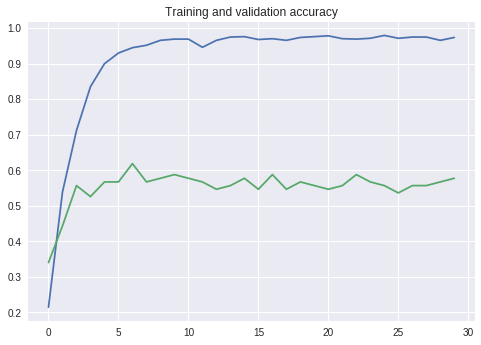

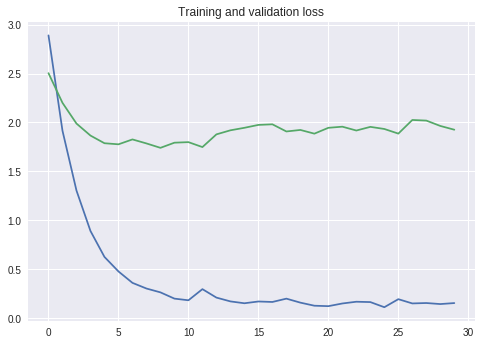

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

##Run 2 with Data Augmentation

In [0]:
#using first set of augmented data
#resumes are tokenized into sentences and then randomly mixed up

url = 'https://raw.githubusercontent.com/hsoJLeu/resumAI/master/data/augmented_resumes.csv'

df = pd.read_csv(url)
df.head()

,ID,Category,Resume
0,1,HR,com \ n \ napproachable innovator passion huma...
1,2,HR,analyze data projections create forecasts narr...
2,3,HR,"smith , p . revamped orientation training \ np..."
3,4,HR,"directly supervise \ nstaff 3 : hr admin , plu..."
4,5,HR,supervised hr \ nassistant 3 temporary human r...


In [0]:
resume_list = df['Resume']            # get resume list
category_list = df['Category']        # get category list
#category_id_list = df['category_id']  # get category id list

##Algorithm for data augmentation, commented out because takes a long time so we wrote it to a .csv and put it in our github

In [0]:
# # Data Augmentation

# import nltk
# nltk.download('punkt')
# from nltk import sent_tokenize
# import json
# import random
# import sys
# import time
# import tqdm
# from tqdm import tqdm
# import csv

# def tokenize(resume):
#     '''text: list of resumes'''
#     tokenized =  sent_tokenize(resume)
#     return tokenized
	
		
# def shuffle_tokenized(resume):
#     random.shuffle(resume)
#     newl=list(resume)
#     shuffled.append(newl)
#     return resume
  
# print(resume_list[0])
# print(category_list[0])
# print(resume_list.size)


# augmented_category = "" 
# reps=[]               #reps = repeated reshuffles
# augmented_count = 0

# resume_list_size = resume_list.size

# print("augmenting ", resume_list_size, " resumes")

# with open('augmented_resumes.csv', mode='w') as augmented_resumes:
#     augmented_writer = csv.writer(augmented_resumes, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
#     augmented_writer.writerow(['ID', 'Category', 'Resume'])
    

#     # for i in tqdm(range(resume_list_size)):
#     for i in tqdm(range(resume_list_size)):
#         augmented = []
        
#         tok = tokenize(resume_list[i])
#         shuffled= [tok]

#         for j in range(10):
#         #generate 10 new resumes
#             shuffle_tokenized(shuffled[-1])

#         for k in shuffled:
#             s = ' '
#             new_resume = s.join(k)
#             new_category = category_list[i]

#             if new_resume not in augmented:
#     #             augmented.append(new_resume)
#                 augmented = np.append(augmented, new_resume)
#                 resume_list = np.append(resume_list, new_resume)
#                 category_list = np.append(category_list, new_category)
#                 augmented_count += 1
#                 augmented_writer.writerow([augmented_count, new_category, new_resume])
#             else:
#                 reps.append(new_resume)
#                 #augmented_category.append(category_list[i])


In [0]:
print(resume_list.size)
print(resume_list)

7022
0       com \ n \ napproachable innovator passion huma...
1       analyze data projections create forecasts narr...
2       smith , p . revamped orientation training \ np...
3       directly supervise \ nstaff 3 : hr admin , plu...
4       supervised hr \ nassistant 3 temporary human r...
5       \ xe2 \ x80 \ x93 tampa , fl \ n \ n2010 \ xe2...
6       \ xe2 \ x80 \ x93 atlanta , ga \ n \ n2008 \ x...
7       communicate early changes dependent coverage ,...
8       c .\ n \ n2004 \ xe2 \ x80 \ x932006 \ n \ npr...
9       bjohn h smith phrn po box callahan fl infogrea...
10      bname surnamenaddressnmobile noemailnpersonal ...
11      com \ n \ nuniversity birmingham ,\ nba ( hons...
12      however cv template must distributed made avai...
13      com .' com . dayjob . com \ n \ nuniversity bi...
14      also welcome link \ nany page site www . dayjo...
15      questions relating use template please email :...
16      dayjob . also welcome link \ nany page site ww...
17      j

In [0]:
# #verifying augmentation worked

# augmented_length = len(augmented)
# reps_length = len(reps)
# print(augmented_length)
# print(reps_length)

# for i in range(3):
#   print(resume_list[-i])

# print("\naugmented resume:")
# for i in range(30):
#   print(reps[-i])
# #   print(augmented[i])

In [0]:
# Split augmented data and category into training and test data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(resume_list, category_list, test_size = 0.2, random_state=0)

In [0]:
len(X_train)
len(y_train)


5617

In [0]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from keras import utils

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(X_train) # only fit on train


x_train = tokenize.texts_to_matrix(X_train)
x_test = tokenize.texts_to_matrix(X_test)

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 10

In [0]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 5055 samples, validate on 562 samples
Epoch 1/10
5055/5055 [==============================] - 1s 207us/step - loss: 1.3032 - acc: 0.6785 - val_loss: 0.3812 - val_acc: 0.9217
Epoch 2/10
5055/5055 [==============================] - 1s 157us/step - loss: 0.4208 - acc: 0.9017 - val_loss: 0.2929 - val_acc: 0.9199
Epoch 3/10
5055/5055 [==============================] - 1s 159us/step - loss: 0.3006 - acc: 0.9272 - val_loss: 0.2314 - val_acc: 0.9342
Epoch 4/10
5055/5055 [==============================] - 1s 158us/step - loss: 0.2447 - acc: 0.9426 - val_loss: 0.1929 - val_acc: 0.9466
Epoch 5/10
5055/5055 [==============================] - 1s 158us/step - loss: 0.1985 - acc: 0.9505 - val_loss: 0.1811 - val_acc: 0.9359
Epoch 6/10
5055/5055 [==============================] - 1s 159us/step - loss: 0.1905 - acc: 0.9527 - val_loss: 0.1571 - val_acc: 0.9466
Epoch 7/10
5055/5055 [==============================] - 1s 157us/step - loss: 0.1674 - acc: 0.9505 - val_loss: 0.1513 - val_acc: 0.9466
E

In [0]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

1405/1405 [==============================] - 0s 56us/step
Test accuracy: 0.9181494666588264


Text(0.5, 1.0, 'Training and validation loss')

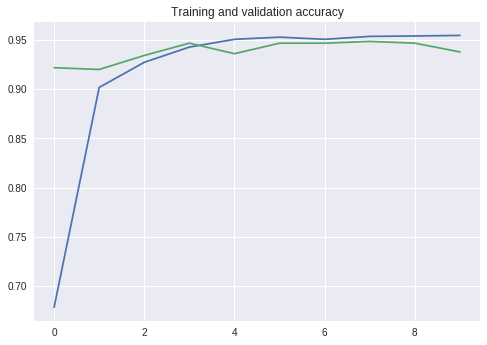

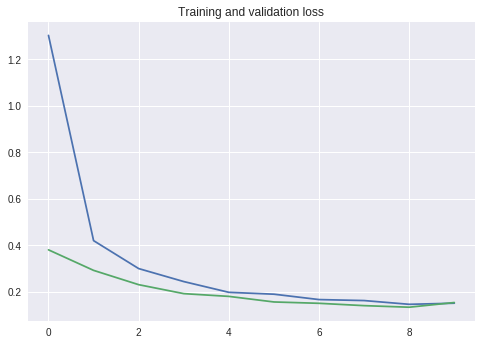

In [0]:
#results for first method of augmentation

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

## Run 3 with keeping training data and validation data separate 

In [0]:
#second method to data augmentation

url = 'https://raw.githubusercontent.com/hsoJLeu/resumAI/master/data/resume_dataset.csv'   

df = pd.read_csv(url)
df.head()

,ID,Category,Resume
0,1,HR,"b'John H. Smith, P.H.R.\n800-991-5187 | PO Box..."
1,2,HR,b'Name Surname\nAddress\nMobile No/Email\nPERS...
2,3,HR,b'Anthony Brown\nHR Assistant\nAREAS OF EXPERT...
3,4,HR,b'www.downloadmela.com\nSatheesh\nEMAIL ID:\nC...
4,5,HR,"b""HUMAN RESOURCES DIRECTOR\n\xef\x82\xb7Expert..."


In [0]:
# Data cleaning

from io import StringIO
col = ['Category', 'Resume']
df = df[col]
df = df[pd.notnull(df['Resume'])]
df.columns = ['Category', 'Resume']
df['category_id'] = df['Category'].factorize()[0]
# clean category -> category Id

# #DROPPING ROW 132 because it messes things up
# df.drop(df.index[132])

category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

# Drop resumes if data contain b'' there are 12 of these in our dataset
# Empty resumes in the dataset, one hot can't encode empty resumes

df = df[df['Resume'].map(len) > 4]

# Get a count for resumes in the dataframe so that we can fix overfitting issues
df['count_resumes'] = df.groupby(['Category', 'category_id'])['category_id'].transform('count')
  
# To look at count of resumes per category  
countDF = df[['Category', 'count_resumes']]
#print("Number of resumes per category:")
countDF.drop_duplicates(subset='Category', keep="first")

df = df.reset_index(drop=True)

In [0]:
resume_list = df['Resume']            # get resume list
category_list = df['Category']        # get category list
category_id_list = df['category_id']  # get category id list

#split into train and test
train=df.sample(frac=0.8,random_state=200)
test=df.drop(train.index)

train_resume_list = train['Resume']            # train resume list
train_category_list = train['Category']        # train category list
train_category_id_list = train['category_id']  # train category id list

test_resume_list = test['Resume']            # test resume list
test_category_list = test['Category']        # test category list
test_category_id_list = test['category_id']  # test category id list

print(len(train))
test_resume_list.head()


965


0     b'John H. Smith, P.H.R.\n800-991-5187 | PO Box...
10    b'RESUME WORLD INC.\n1200 Markham Road, Suite ...
15    b'Anthony Brown\nHR Assistant\nAREAS OF EXPERT...
17    b'Human Resources Manager\nCurriculum Vitae Ex...
27    b'RESUME WORLD INC.\n1200 Markham Road, Suite ...
Name: Resume, dtype: object

In [0]:
# This part applies regex and cleans data in resume field 

nltk.download('stopwords')
import re

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    # Get rid of the unicodes starting with \
    doc = re.sub(r'[^\x00-\xff]',r'', doc) 
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)
norm_corpus = normalize_corpus(resume_list)
#norm_corpus # this is a numpy array & cleaned out data

# test
resume_list = norm_corpus
#resume_list

train_norm_corpus = normalize_corpus(train_resume_list)
#train_norm_corpus 
train_resume_list = train_norm_corpus 
#train_norm_corpus

test_norm_corpus = normalize_corpus(test_resume_list)
#test_norm_corpus 
test_resume_list = test_norm_corpus 
#test_norm_corpus



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
len(train_resume_list)
len(train_category_list)

965

In [0]:
print(train_category_list[132])

Managment


## Data Augmentation 
### This may take awhile...

In [0]:
# add augmentation here

# Data Augmentation

import nltk
nltk.download('punkt')
from nltk import sent_tokenize
import json
import random
import sys
import time
import tqdm
from tqdm import tqdm

def tokenize(resume):
    '''text: list of resumes'''
    tokenized =  sent_tokenize(resume)
    return tokenized
		
def shuffle_tokenized(resume):
    random.shuffle(resume)
    newl=list(resume)
    shuffled.append(newl)
    return resume


reps=[]               #reps = repeated reshuffles


print("augmenting ", len(train_resume_list), " training resumes")
for i in tqdm(range(len(train_resume_list))):
  
    augmented = []
    #print("augmenting resume: ", i)
    tok = tokenize(train_resume_list[i])
    shuffled= [tok]

    for j in range(3):
    #generate 10 new resumes
        shuffle_tokenized(shuffled[-1])

    for k in shuffled:
    # 		    '''create new review by joining the shuffled sentences'''
        s = ' '
        new_resume = s.join(k)
        new_category = category_list[i]
        
        if new_resume not in augmented:
            augmented.append(new_resume)
            train_resume_list = np.append(train_resume_list, new_resume)
            train_category_list = np.append(train_category_list, new_category)
   
        else:
            reps.append(new_resume)
            

    #print(augmented)
    del augmented[:]
    
    
# print("augmenting ", len(test_resume_list), " testing resumes")
# for i in tqdm(range(len(test_resume_list))):
  
#     augmented = []
#     tok = tokenize(test_resume_list[i])
#     shuffled= [tok]

#     for j in range(10):
#     #generate 10 new resumes
#         shuffle_tokenized(shuffled[-1])

#     for k in shuffled:
#     # 		    '''create new review by joining the shuffled sentences'''
#         s = ' '
#         new_resume = s.join(k)
#         new_category = category_list[i]
        
#         if new_resume not in augmented:
#             augmented.append(new_resume)
#             test_resume_list = np.append(test_resume_list, new_resume)
#             test_category_list = np.append(test_category_list, new_category)
   
#         else:
#             reps.append(new_resume)
            

#     #print(augmented)
#     del augmented[:]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


  0%|          | 0/965 [00:00<?, ?it/s]

augmenting  965  training resumes


100%|██████████| 965/965 [08:38<00:00,  2.13it/s]


In [0]:
#X_train = train_resume_list
#y_train = train_category_list
#X_test = test_resume_list
#y_test = test_category_list


max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_resume_list) # only fit on train


x_train = tokenize.texts_to_matrix(train_resume_list)
x_test = tokenize.texts_to_matrix(test_resume_list)

encoder = LabelEncoder()
encoder.fit(train_category_list)
train_category_list = encoder.transform(train_category_list)
test_category_list = encoder.transform(test_category_list)

num_classes = np.max(train_category_list) + 1
train_category_list = utils.to_categorical(train_category_list, num_classes)
test_category_list = utils.to_categorical(test_category_list, num_classes)

batch_size = 32
epochs = 10


In [0]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
history = model.fit(x_train, train_category_list,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 2736 samples, validate on 305 samples
Epoch 1/10
2736/2736 [==============================] - 3s 1ms/step - loss: 2.8594 - acc: 0.1689 - val_loss: 3.4578 - val_acc: 0.0066
Epoch 2/10
2736/2736 [==============================] - 0s 166us/step - loss: 2.1462 - acc: 0.3761 - val_loss: 3.6483 - val_acc: 0.0426
Epoch 3/10
2736/2736 [==============================] - 0s 174us/step - loss: 1.7659 - acc: 0.4909 - val_loss: 4.4288 - val_acc: 0.0295
Epoch 4/10
2736/2736 [==============================] - 0s 151us/step - loss: 1.5515 - acc: 0.5150 - val_loss: 4.3986 - val_acc: 0.0361
Epoch 5/10
2736/2736 [==============================] - 0s 169us/step - loss: 1.4111 - acc: 0.5548 - val_loss: 4.7310 - val_acc: 0.0393
Epoch 6/10
2736/2736 [==============================] - 0s 161us/step - loss: 1.3479 - acc: 0.5479 - val_loss: 4.5602 - val_acc: 0.0492
Epoch 7/10
2736/2736 [==============================] - 0s 166us/step - loss: 1.2671 - acc:

In [0]:
score = model.evaluate(x_test, test_category_list,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

241/241 [==============================] - 0s 120us/step
Test accuracy: 0.37344398371164234


Text(0.5, 1.0, 'Training and validation loss')

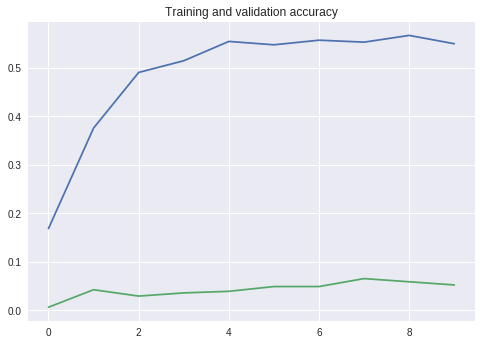

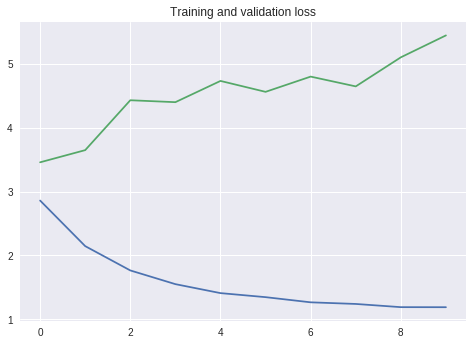

In [0]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

###Below is our third attempt at augmentation. This time we use embeddings to replace common words with synonyms.


#### NOTE TO PROFESSORS AND TA's: Our embedded words are currently in our local google drives. We want to upload them into our notebook. For professors and graders, please download the word embeddings folder here: 
https://drive.google.com/open?id=1RKAx9gAaTQldIfPuEl-ke1mNC0THTqzS





In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

np.random.seed(100)

# Loading word embedddings 

In order to successfully load word embeddings, the person running the notebook must 

##Enter the path to the project folder here on line 8

In [0]:
# USE THIS TO UPLOAD WORD EMBEDDINGS IF NOT USING GOOGLE COLAB

from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: ignored

In [0]:
#ENTER PATH TO EMBEDDINGS FOLDER ON LINE 8!

def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')  
  
def load_embedding(file):
#     if file == '/content/drive/My Drive/CMPS 144/ResumAI/resources/quora-insincere-questions-classification/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
    if file == '.../embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
    return embeddings_index

In [0]:
def make_embedding_matrix(embedding, tokenizer, len_voc):
    all_embs = np.stack(embedding.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    word_index = tokenizer.word_index
    embedding_matrix = np.random.normal(emb_mean, emb_std, (len_voc, embed_size))
    
    for word, i in word_index.items():
        if i >= len_voc:
            continue
        embedding_vector = embedding.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

##Enter the path to the project folder here too

In [0]:
# Uncomment the below to load your downloaded glove vectors into the embedding function
# glove = load_embedding(uploaded)

# Otherwise this is for the google drive authenticated version
glove = load_embedding('.../embeddings/glove.840B.300d/glove.840B.300d.txt')
# glove = load_embedding('/content/drive/My Drive/CMPS 144/ResumAI/resources/quora-insincere-questions-classification/embeddings/glove.840B.300d/glove.840B.300d.txt')

In [0]:
# load data

url = 'https://raw.githubusercontent.com/hsoJLeu/resumAI/master/data/resume_dataset.csv'              

df = pd.read_csv(url)
print("Number of texts: ", df.shape[0])

In [0]:
df.head()

In [0]:
# Data cleaning

from io import StringIO
col = ['Category', 'Resume']
df = df[col]
df = df[pd.notnull(df['Resume'])]
df.columns = ['Category', 'Resume']
df['category_id'] = df['Category'].factorize()[0]
# clean category -> category Id

# #DROPPING ROW 132 because it messes things up
# df.drop(df.index[132])

category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

# Drop resumes if data contain b'' there are 12 of these in our dataset
# Empty resumes in the dataset, one hot can't encode empty resumes

df = df[df['Resume'].map(len) > 4]

# Get a count for resumes in the dataframe so that we can fix overfitting issues
df['count_resumes'] = df.groupby(['Category', 'category_id'])['category_id'].transform('count')
  
# To look at count of resumes per category  
countDF = df[['Category', 'count_resumes']]
#print("Number of resumes per category:")
countDF.drop_duplicates(subset='Category', keep="first")

df = df.reset_index(drop=True)

In [0]:
len_voc = 100000

In [0]:
def make_tokenizer(texts, len_voc):
    from keras.preprocessing.text import Tokenizer
    t = Tokenizer(num_words=len_voc, split=' ', char_level=False,)
    t.fit_on_texts(texts)
    return t

In [0]:
tokenizer = make_tokenizer(df['Resume'], len_voc)

In [0]:
X = tokenizer.texts_to_sequences(df['Resume'])

In [0]:
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X, 70)

In [0]:
index_word = {0: ''}
for word in tokenizer.word_index.keys():
    index_word[tokenizer.word_index[word]] = word

In [0]:
embed_mat = make_embedding_matrix(glove, tokenizer, len_voc)

## Compute 5 synonyms for the 20000 most frequent words.

In [0]:
from sklearn.neighbors import NearestNeighbors

synonyms_number = 5
word_number = 20000

In [0]:
nn = NearestNeighbors(n_neighbors=synonyms_number+1).fit(embed_mat) 

In [0]:
neighbours_mat = nn.kneighbors(embed_mat[1:word_number])[1]

In [0]:
synonyms = {x[0]: x[1:] for x in neighbours_mat}

In [0]:
for x in np.random.randint(1, word_number, 20):
    print(f"{index_word[x]} : {[index_word[synonyms[x][i]] for i in range(synonyms_number-1)]}")

In [0]:
# X_pos = X[y==1]

resume_list = df['Resume']            # get resume list
category_list = df['Category']        # get category list
category_id_list = df['category_id']  # get category id list

#split into train and test
train=df.sample(frac=0.8,random_state=200)
test=df.drop(train.index)

train_resume_list = train['Resume']            # train resume list
train_category_list = train['Category']        # train category list
train_category_id_list = train['category_id']  # train category id list

test_resume_list = test['Resume']            # test resume list
test_category_list = test['Category']        # test category list
test_category_id_list = test['category_id']  # test category id list

print(len(train))
test_resume_list.head()

In [0]:
# This part applies regex and cleans data in resume field 

nltk.download('stopwords')
import re

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    # Get rid of the unicodes starting with \
    doc = re.sub(r'[^\x00-\xff]',r'', doc) 
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)
norm_corpus = normalize_corpus(resume_list)
#norm_corpus # this is a numpy array & cleaned out data

# test
resume_list = norm_corpus
#resume_list

train_norm_corpus = normalize_corpus(train_resume_list)
#train_norm_corpus 
train_resume_list = train_norm_corpus 
#train_norm_corpus

test_norm_corpus = normalize_corpus(test_resume_list)
#test_norm_corpus 
test_resume_list = test_norm_corpus 
#test_norm_corpus

In [0]:
def modify_sentence(sentence, synonyms, p=0.5):
    for i in range(len(sentence)):
#         if np.random.random() > p:
            try:
                syns = synonyms[sentence[i]]
                sentence[i] = np.random.choice(syns)
            except KeyError:
                pass
    return sentence

In [0]:
import nltk
nltk.download('punkt')
from nltk import sent_tokenize
import json
import random
import sys
import time

def tokenize(resume):
    '''text: list of resumes'''
    tokenized =  word_tokenize(resume)
    return tokenized
		
def shuffle_tokenized(resume):
    random.shuffle(resume)
    newl=list(resume)
    shuffled.append(newl)
    return resume
  
# x = 1
# tok = np.random.randint(1, word_number, 20)
# print(len(tok))
# print(tok)
# # print(train_resume_list[x])
# modified = modify_sentence(tok, synonyms)
# resume_m = ' '.join(modified)
# print(resume_m)

for x in range(20):
    sample =  np.random.randint(1, word_number, 20)
#     tok = tokenize(train_resume_list[x])
#     tok = tokenize(np.random.randint)
    
    for i in range(20):
        
    
#     sample = resume_list[x]
        sentence = ' '.join([index_word[i] for i in sample])
        print(sentence)

        modified = modify_sentence(sample, synonyms)
        sentence_m = ' '.join([index_word[i] for i in modified])
        print(sentence_m)
    
    print(' ')